In [6]:
import os
from torchvision.utils import make_grid
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

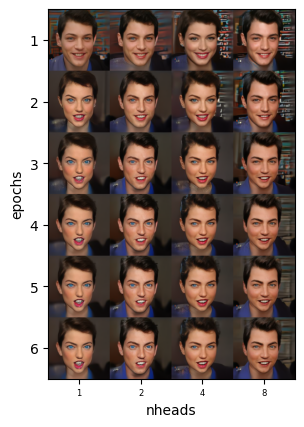

In [15]:
def ablation_epochs_vs_heads(reconstructed=False, image_idx=0, save_img=True):
    basepath = Path("/home/parting/master_AI/DL2/DL2-2023-group-15/src/eval_runs/heads_ablation")

    nheads = [1,2,4,8]
    epochs = [0,1,2,3,4,5]

    image_rows = []
    for nhead in nheads:
        image_row = []
        for epoch in epochs:
            if reconstructed:
                image_path = basepath / f"h{nhead}" / f"{epoch}" / "40" / "reconstructed" / f"test_{image_idx}_19_ngen40_reconstructed.png"
            else:
                image_path = basepath / f"h{nhead}" / f"{epoch}" / "40" / "edited" / f"test_{image_idx}_19_ngen40_edited.png"

            # read image
            image_array = np.array(Image.open(image_path).convert('RGB'))
            # if epoch == 0:
            #     image_array[:100] = 0

            image_row.append(image_array)
        row = np.concatenate(image_row, axis=0)
        image_rows.append(row)
    image_grid = np.concatenate(image_rows, axis=1)

    fig,ax = plt.subplots(1)
    ax.set_xticks([256] * np.arange(4) + 128, ("1","2","4","8"))
    ax.set_yticks([256] * np.arange(6) + 128, ("1","2","3","4", "5", "6"))
    ax.set_ylabel('epochs')
    ax.set_xlabel('nheads')
    plt.imshow(image_grid)
    if save_img:
        if reconstructed:
            plt.savefig(f"epochs_vs_heads_img{image_idx}_recon.png", bbox_inches='tight', pad_inches=0, dpi=300)
        else:    
            plt.savefig(f"epochs_vs_heads_img{image_idx}.png", bbox_inches='tight', pad_inches=0, dpi=300)
    plt.show()

# for i in range(5):
ablation_epochs_vs_heads(image_idx=20, reconstructed=False, save_img=False)

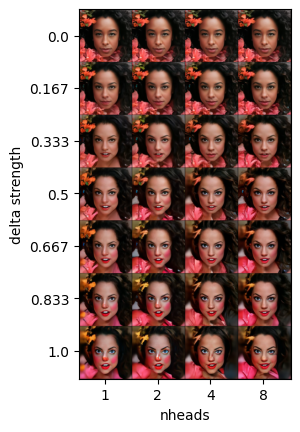

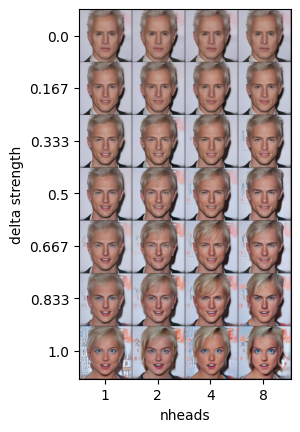

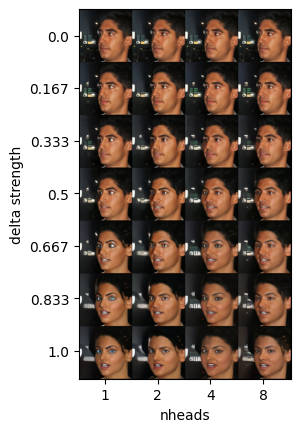

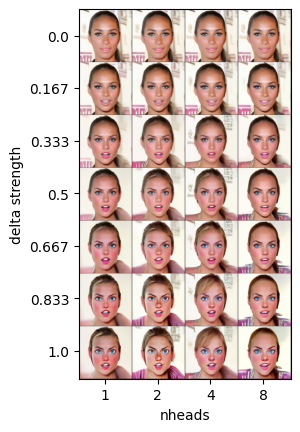

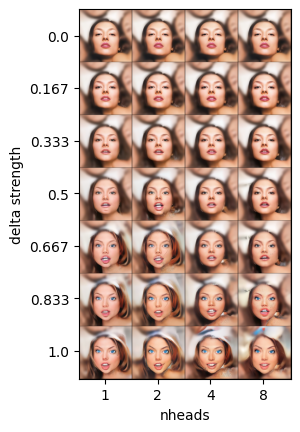

In [100]:
def ablation_epochs_vs_deltas(reconstructed=False, image_idx=0):
    basepath = Path("/home/parting/master_AI/DL2/DL2-2023-group-15/src/eval_runs/dstrength_ablation")

    nheads = [1,2,4,8]

    image_cols = []
    for nhead in nheads:
        image_path = basepath / f"h{nhead}" / "40" / f"test_{image_idx}_19_ngen40.png"

        # read image
        image_array = np.array(Image.open(image_path).convert('RGB'))

        image_cols.append(image_array)

    image_grid = np.concatenate(image_cols, axis=1)

    fig,ax = plt.subplots(1)
    ax.set_xticks([256] * np.arange(4) + 128, ("1","2","4","8"))
    # from script
    min_delta = 0
    max_delta = 1
    num_delta = 7
    strengths = np.linspace(min_delta, max_delta, num_delta)
    strengths = [f"{s:.3}" for s in strengths]
    ax.set_yticks([256] * np.arange(7) + 128, strengths)
    ax.set_ylabel('delta strength')
    ax.set_xlabel('nheads')
    plt.imshow(image_grid)
    plt.savefig(f"dstrength_vs_heads_img{image_idx}.png", bbox_inches='tight', pad_inches=0, dpi=300)
    # plt.show()

for i in range(5):
    ablation_epochs_vs_deltas(image_idx=i)

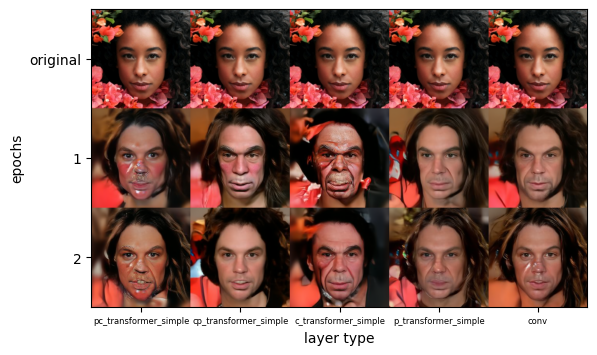

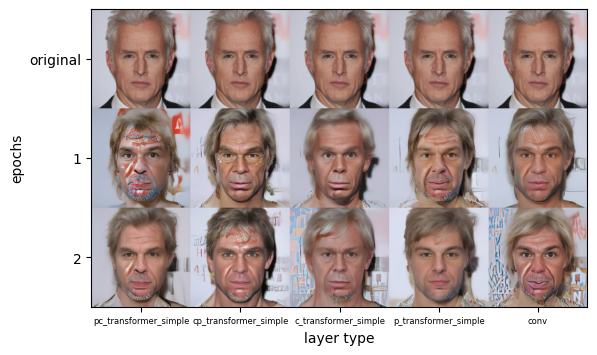

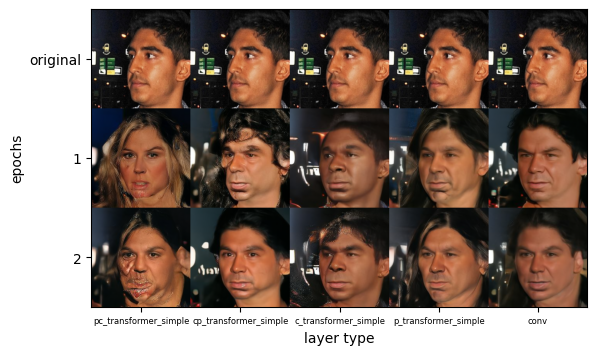

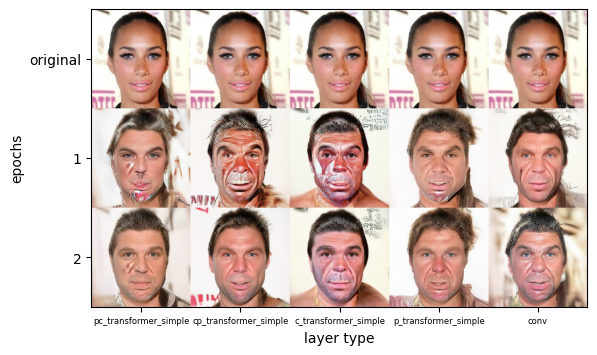

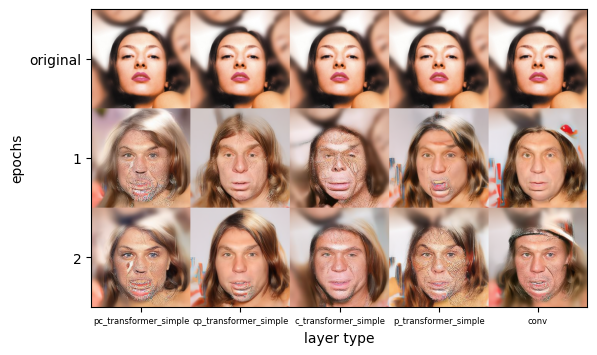

In [18]:
def ablation_epochs_vs_layer(reconstructed=False, image_idx=0):
    basepath = Path("/home/parting/master_AI/DL2/DL2-2023-group-15/src/eval_runs/layertype_ablation")

    layertype = ['pc_transformer_simple', 'cp_transformer_simple', 'c_transformer_simple', 'p_transformer_simple', 'conv']
    # epochs = [0,1,2,3,4,5]
    epochs = [-1, 0,1]

    image_rows = []

    for layer in layertype:
        image_row = []
        # add original image
        image_path = basepath / f"{layer}" / "0" / "40" / "original" / f"test_{image_idx}_19_ngen40_original.png"
        image_array = np.array(Image.open(image_path).convert('RGB'))
        image_row.append(image_array)

        for epoch in epochs:
            #skip first epoch as its for original images
            if epoch == -1:
                continue

            image_path = basepath / f"{layer}" / f"{epoch}" / "40" / "edited" / f"test_{image_idx}_19_ngen40_edited.png"

            # read image
            image_array = np.array(Image.open(image_path).convert('RGB'))
            # if epoch == 0:
            #     image_array[:100] = 0

            image_row.append(image_array)
        row = np.concatenate(image_row, axis=0)
        image_rows.append(row)
    image_grid = np.concatenate(image_rows, axis=1)

    fig,ax = plt.subplots(1)
    ax.set_xticks([256] * np.arange(len(layertype)) + 128, layertype)
    ax.set_yticks([256] * np.arange(len(epochs)) + 128, ("original", "1","2"))
    ax.set_ylabel('epochs')
    ax.set_xlabel('layer type')
    
    plt.imshow(image_grid)
    # plt.savefig(f"epochs_vs_layer_img{image_idx}.png", bbox_inches='tight', pad_inches=0, dpi=300)

    plt.show()

plt.rc('xtick', labelsize=6)
for i in range(5):
    ablation_epochs_vs_layer(image_idx=i)

# FID & Direction Clip loss calculations

In [1]:
import json
import os
import sys
from glob import glob
from pathlib import Path

import torch
import torchvision.transforms as transforms
from PIL import Image
from pytorch_fid import fid_score
from tqdm import tqdm

# make imports work from the asyrp repository
sys.path.append("../")

from losses.clip_loss import CLIPLoss
from utils.text_dic import SRC_TRG_TXT_DIC
from IPython.utils import io

device = "cuda:0"

clip_loss_func = CLIPLoss(
            device,
            lambda_direction=1,
            lambda_patch=0,
            lambda_global=0,
            lambda_manifold=0,
            lambda_texture=0,
            direction_loss_type='cosine',
            clip_model='ViT-B/32')

# Disable


In [2]:
transform = transforms.Compose([
    transforms.PILToTensor()
])

guid = "pixar"

(src_texts, target_texts) = SRC_TRG_TXT_DIC[guid]

with torch.no_grad():
    path1 = "/home/parting/master_AI/DL2/DL2-2023-group-15/src/eval_runs/heads_ablation/h1/0/40/edited/test_0_19_ngen40_edited.png"
    path2 = "/home/parting/master_AI/DL2/DL2-2023-group-15/src/eval_runs/heads_ablation/h1/5/40/edited/test_0_19_ngen40_edited.png"
    path3 = "/home/parting/master_AI/DL2/DL2-2023-group-15/src/eval_runs/heads_ablation/h1/0/40/reconstructed/test_0_19_ngen40_reconstructed.png"
    src_img = Image.open(path2)
    target_img = Image.open(path3)

    src_img_tensor = transform(src_img).float().to(device)[None, :]
    target_img_tensor = transform(target_img).float().to(device)[None, :]

    clip_loss_intermediate = clip_loss_func.clip_directional_loss(src_img_tensor, src_texts, target_img_tensor, target_texts)
    clip_loss = -torch.log((2 - clip_loss_intermediate) / 2)
    print(clip_loss_intermediate)
    print(clip_loss)

    del src_img_tensor, target_img_tensor
    # total_clip_loss += clip_loss

/home/parting/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor(0.9619, device='cuda:0', dtype=torch.float16)
tensor(0.6558, device='cuda:0', dtype=torch.float16)


In [ ]:
tensor(0.9736, device='cuda:0', dtype=torch.float16)
tensor(0.6670, device='cuda:0', dtype=torch.float16)

In [3]:
def calculate_clip_loss(image_folder_path, guid):
    (src_texts, target_texts) = SRC_TRG_TXT_DIC[guid]

    transform = transforms.Compose([
        transforms.PILToTensor()
    ])

    images = glob(image_folder_path + "/*.png")
    total_clip_loss = 0
    with torch.no_grad():
        for image_path in tqdm(images, total=len(images), desc="parsing images for clip loss"):
            src_img = Image.open(image_path.replace("edited", "reconstructed"))
            target_img = Image.open(image_path)

            src_img_tensor = transform(src_img).float().to(device)[None, :]
            target_img_tensor = transform(target_img).float().to(device)[None, :]

            clip_loss_intermediate = clip_loss_func.clip_directional_loss(src_img_tensor, src_texts, target_img_tensor, target_texts)
            # clip_loss = -torch.log((2 - clip_loss_intermediate) / 2)
            # print(clip_loss)

            del src_img_tensor, target_img_tensor
            total_clip_loss += clip_loss_intermediate

    return total_clip_loss / len(images)


In [4]:
# see text in text_dic.py
guid = "pixar"

basepath = Path("/home/parting/master_AI/DL2/DL2-2023-group-15/src/eval_runs/heads_ablation")

results = {}

for path in os.walk(basepath, topdown=False):
    if "h2" not in path[0]:
        continue 

    # find ablation paths
    if "40/edited" in str(path):
        print(f"parsing: {path[0]}")
        # path magic
        epoch = path[0].split("/40")[0][-1]
        ablation_type = path[0].split("eval_runs/")[-1]
        ablation_type = ablation_type.split("/40")[0]
        ablation_type, epoch = ablation_type[:-2], ablation_type[-1:]
        
        path_edited = path[0]
        path_recon = path[0].replace("edited", "reconstructed")
        path_original = path[0].replace("edited", "original")
        
        mean_clip_direction_loss = calculate_clip_loss(path_edited, guid)
        print("=" * 50)
        print(f"ablation: '{ablation_type}' on epoch {epoch}, gives mean clip direction loss: {mean_clip_direction_loss}")
        
        print("calculating FID")
        with io.capture_output() as captured:
        # fid scores
            score_er = fid_score.calculate_fid_given_paths(
                [path_edited, path_recon],
                batch_size=32,
                device="cuda:0",
                dims=2048
            )
            score_eo = fid_score.calculate_fid_given_paths(
                [path_edited, path_original],
                batch_size=32,
                device="cuda:0",
                dims=2048
            )
            score_ro = fid_score.calculate_fid_given_paths(
                [path_recon, path_original],
                batch_size=32,
                device="cuda:0",
                dims=2048
            )
            score_oo = fid_score.calculate_fid_given_paths(
                [path_original, path_original],
                batch_size=32,
                device="cuda:0",
                dims=2048
            )

        print(f"ablation: '{ablation_type}' on epoch {epoch}, gives FID: {score_er} between edited and reconstructed")
        print(f"ablation: '{ablation_type}' on epoch {epoch}, gives FID: {score_eo} between edited and original")
        print(f"ablation: '{ablation_type}' on epoch {epoch}, gives FID: {score_ro} between reconstructed and original")
        print(f"ablation: '{ablation_type}' on epoch {epoch}, gives FID: {score_oo} between original and original")
        print("+" * 50)
        run_results = {
            "fid_edited_reconstructed": score_er,
            "fid_edited_original": score_eo,
            "epochs": epoch,
            "ablation_name": ablation_type,
            "mean_clip_direction_loss": mean_clip_direction_loss
        }
        
        results[ablation_type + f"_{epoch}"] = run_results


parsing: /home/parting/master_AI/DL2/DL2-2023-group-15/src/eval_runs/heads_ablation/h2/3/40/edited


parsing images for clip loss: 100%|██████████| 100/100 [00:02<00:00, 45.11it/s]


calculating FID
ablation: 'heads_ablation/h2' on epoch 3, gives mean clip direction loss: 0.71630859375
ablation: 'heads_ablation/h2' on epoch 3, gives FID: 84.47347487764245 between edited and reconstructed
ablation: 'heads_ablation/h2' on epoch 3, gives FID: 111.06096532922817 between edited and original
ablation: 'heads_ablation/h2' on epoch 3, gives FID: 96.11018473790887 between reconstructed and original
ablation: 'heads_ablation/h2' on epoch 3, gives FID: -6.612987289145167e-05 between original and original
++++++++++++++++++++++++++++++++++++++++++++++++++
parsing: /home/parting/master_AI/DL2/DL2-2023-group-15/src/eval_runs/heads_ablation/h2/4/40/edited


parsing images for clip loss: 100%|██████████| 100/100 [00:01<00:00, 55.54it/s]


calculating FID
ablation: 'heads_ablation/h2' on epoch 4, gives mean clip direction loss: 0.71630859375
ablation: 'heads_ablation/h2' on epoch 4, gives FID: 85.71210478505645 between edited and reconstructed
ablation: 'heads_ablation/h2' on epoch 4, gives FID: 112.36607443354785 between edited and original
ablation: 'heads_ablation/h2' on epoch 4, gives FID: 96.11018473790887 between reconstructed and original
ablation: 'heads_ablation/h2' on epoch 4, gives FID: -6.612987289145167e-05 between original and original
++++++++++++++++++++++++++++++++++++++++++++++++++
parsing: /home/parting/master_AI/DL2/DL2-2023-group-15/src/eval_runs/heads_ablation/h2/0/40/edited


parsing images for clip loss: 100%|██████████| 100/100 [00:01<00:00, 56.94it/s]


calculating FID
ablation: 'heads_ablation/h2' on epoch 0, gives mean clip direction loss: 0.7255859375
ablation: 'heads_ablation/h2' on epoch 0, gives FID: 79.65859607722328 between edited and reconstructed
ablation: 'heads_ablation/h2' on epoch 0, gives FID: 108.85650741177511 between edited and original
ablation: 'heads_ablation/h2' on epoch 0, gives FID: 96.11018473790887 between reconstructed and original
ablation: 'heads_ablation/h2' on epoch 0, gives FID: -6.612987289145167e-05 between original and original
++++++++++++++++++++++++++++++++++++++++++++++++++
parsing: /home/parting/master_AI/DL2/DL2-2023-group-15/src/eval_runs/heads_ablation/h2/2/40/edited


parsing images for clip loss: 100%|██████████| 100/100 [00:01<00:00, 55.61it/s]


calculating FID
ablation: 'heads_ablation/h2' on epoch 2, gives mean clip direction loss: 0.71630859375
ablation: 'heads_ablation/h2' on epoch 2, gives FID: 84.34884604921417 between edited and reconstructed
ablation: 'heads_ablation/h2' on epoch 2, gives FID: 111.49100344145654 between edited and original
ablation: 'heads_ablation/h2' on epoch 2, gives FID: 96.11018473790887 between reconstructed and original
ablation: 'heads_ablation/h2' on epoch 2, gives FID: -6.612987289145167e-05 between original and original
++++++++++++++++++++++++++++++++++++++++++++++++++
parsing: /home/parting/master_AI/DL2/DL2-2023-group-15/src/eval_runs/heads_ablation/h2/5/40/edited


parsing images for clip loss: 100%|██████████| 100/100 [00:01<00:00, 50.04it/s]


calculating FID
ablation: 'heads_ablation/h2' on epoch 5, gives mean clip direction loss: 0.71484375
ablation: 'heads_ablation/h2' on epoch 5, gives FID: 86.15020206171044 between edited and reconstructed
ablation: 'heads_ablation/h2' on epoch 5, gives FID: 112.69021421197172 between edited and original
ablation: 'heads_ablation/h2' on epoch 5, gives FID: 96.11018473790887 between reconstructed and original
ablation: 'heads_ablation/h2' on epoch 5, gives FID: -6.612987289145167e-05 between original and original
++++++++++++++++++++++++++++++++++++++++++++++++++
parsing: /home/parting/master_AI/DL2/DL2-2023-group-15/src/eval_runs/heads_ablation/h2/1/40/edited


parsing images for clip loss: 100%|██████████| 100/100 [00:01<00:00, 51.02it/s]


calculating FID
ablation: 'heads_ablation/h2' on epoch 1, gives mean clip direction loss: 0.72607421875
ablation: 'heads_ablation/h2' on epoch 1, gives FID: 81.36817141438455 between edited and reconstructed
ablation: 'heads_ablation/h2' on epoch 1, gives FID: 112.97332051035983 between edited and original
ablation: 'heads_ablation/h2' on epoch 1, gives FID: 96.11018473790887 between reconstructed and original
ablation: 'heads_ablation/h2' on epoch 1, gives FID: -6.612987289145167e-05 between original and original
++++++++++++++++++++++++++++++++++++++++++++++++++


In [11]:
results

{'heads_ablation/h2_3': {'fid_edited_reconstructed': 84.47347487764245,
  'fid_edited_original': 111.06096532922817,
  'epochs': '3',
  'ablation_name': 'heads_ablation/h2'},
 'heads_ablation/h2_4': {'fid_edited_reconstructed': 85.71210478505645,
  'fid_edited_original': 112.36607443354785,
  'epochs': '4',
  'ablation_name': 'heads_ablation/h2'},
 'heads_ablation/h2_0': {'fid_edited_reconstructed': 79.65859607722328,
  'fid_edited_original': 108.85650741177511,
  'epochs': '0',
  'ablation_name': 'heads_ablation/h2'},
 'heads_ablation/h2_2': {'fid_edited_reconstructed': 84.34884604921417,
  'fid_edited_original': 111.49100344145654,
  'epochs': '2',
  'ablation_name': 'heads_ablation/h2'},
 'heads_ablation/h2_5': {'fid_edited_reconstructed': 86.15020206171044,
  'fid_edited_original': 112.69021421197172,
  'epochs': '5',
  'ablation_name': 'heads_ablation/h2'},
 'heads_ablation/h2_1': {'fid_edited_reconstructed': 81.36817141438455,
  'fid_edited_original': 112.97332051035983,
  'epoch

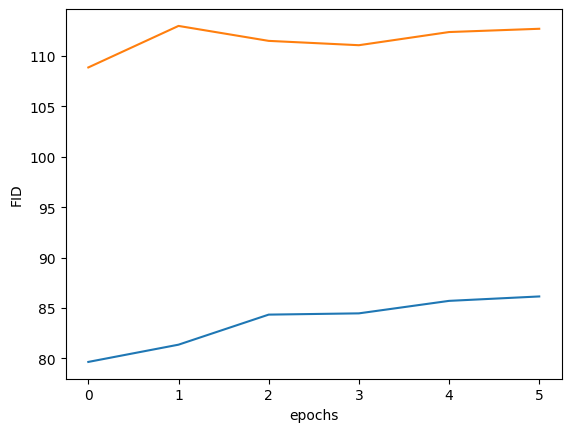

In [23]:
import matplotlib.pyplot as plt

fid_er = [(results[key]['fid_edited_reconstructed'], results[key]['epochs']) for key in results.keys()]
fid_er = sorted(fid_er, key=lambda x: x[1])
fid_er = [t[0] for t in fid_er]

fid_eo = [(results[key]['fid_edited_original'], results[key]['epochs']) for key in results.keys()]
fid_eo = sorted(fid_eo, key=lambda x: x[1])
fid_eo = [t[0] for t in fid_eo]

plt.plot(range(len(fid_er)), fid_er)
plt.plot(range(len(fid_eo)), fid_eo)
plt.xlabel("epochs")
plt.ylabel("FID")
plt.show()

In [ ]:
# write results to json file
with open("fid_scores.json", "w") as f:
    f.write(json.dumps(results, indent=4))
    results